In [1]:
import numpy as np # linear algebra, 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
price = pd.read_csv('prices.csv')
price.head()

,date,symbol,open,close,low,high,volume
0,1/02/2013,ZTS,31.50,31.010000,30.469999,31.74,66789100
1,4/02/2013,ZTS,31.09,31.020000,30.760000,31.99,7695400
2,5/02/2013,ZTS,31.25,31.040001,30.850000,31.98,5013200
3,6/02/2013,ZTS,30.98,31.030001,30.750000,31.43,2126100
4,7/02/2013,ZTS,31.00,32.000000,31.000000,32.73,3800800


In [17]:
# we are not interested in the date,
# given that each observation is separated by almost the same interval of one day.
company = price[price['symbol']=='MSFT']
#company.head()
companyStock = company.close.values.astype('float32')
companyStock = companyStock.reshape(len(companyStock), 1)
companyStock

array([[ 30.95000076],
       [ 30.95999908],
       [ 30.77000046],
       ..., 
       [ 62.99000168],
       [ 62.90000153],
       [ 62.13999939]], dtype=float32)

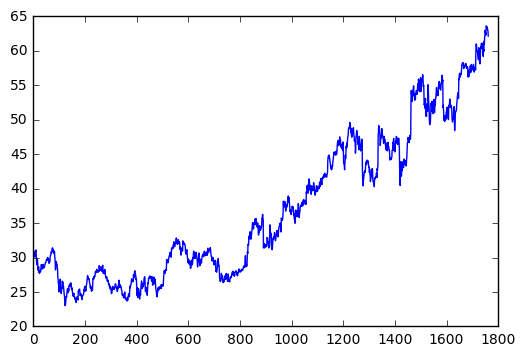

In [4]:
plt.plot(companyStock)
plt.show()

In [5]:
# rescale the data to the range of 0-to-1 (normalizing data)
scaler = MinMaxScaler(feature_range=(0, 1))
companyStock = scaler.fit_transform(companyStock)

In [6]:
# split into 70% train and 30% test sets
train_size = int(len(companyStock) * 0.7)
test_size = len(companyStock) - train_size
train, test = companyStock[0:train_size,:], companyStock[train_size:len(companyStock),:]
print(len(train), len(test))

1233 529


In [7]:
# convert an array of values into a dataset matrix
# it creates a dataset where X is the number of passengers at a given time (t), 
# and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
# look_back is the setting for size of time window
# if look_back = 1, which means we are using nextday model
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
# build model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# train model
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
5s - loss: 0.0145
Epoch 2/10
4s - loss: 0.0010
Epoch 3/10
4s - loss: 1.3634e-04
Epoch 4/10
3s - loss: 1.3516e-04
Epoch 5/10
3s - loss: 1.3850e-04
Epoch 6/10
3s - loss: 1.3425e-04
Epoch 7/10
3s - loss: 1.3288e-04
Epoch 8/10
3s - loss: 1.2951e-04
Epoch 9/10
3s - loss: 1.3092e-04
Epoch 10/10
3s - loss: 1.2871e-04


In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.48 RMSE
Test Score: 1.32 RMSE


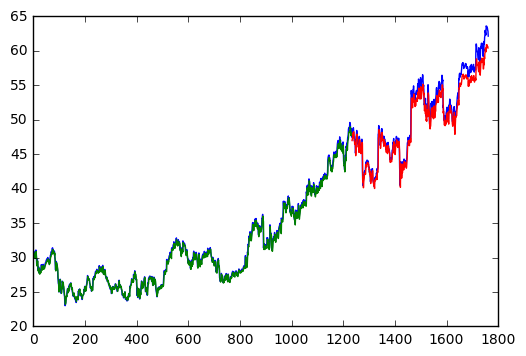

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(companyStock)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(companyStock)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(companyStock))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [14]:
# rerun the model with time window of 10 days
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
4s - loss: 0.0035
Epoch 2/10
4s - loss: 4.2290e-04
Epoch 3/10
4s - loss: 3.5204e-04
Epoch 4/10
3s - loss: 3.0670e-04
Epoch 5/10
3s - loss: 2.8283e-04
Epoch 6/10
3s - loss: 2.5410e-04
Epoch 7/10
3s - loss: 2.4637e-04
Epoch 8/10
4s - loss: 2.2734e-04
Epoch 9/10
3s - loss: 2.2294e-04
Epoch 10/10
3s - loss: 2.1695e-04


In [15]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.60 RMSE
Test Score: 1.31 RMSE


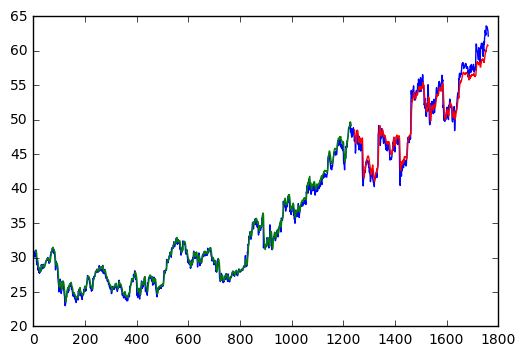

In [16]:
trainPredictPlot = np.empty_like(companyStock)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(companyStock)-1, :] = testPredict
plt.plot(scaler.inverse_transform(companyStock))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()